# Random Forests

Na primeira parte do treinamento sobre modelagem preditiva, entendemos alguns conceitos fundamentais sobre como ocorre uma tarefa de aprendizado supervisionado:

- variável resposta continua (y) e uma ou mais variáveis preditoras (X)
- função de erro que será minimizada no processo de treinamento
- parâmetros que serão ajustados para minimizar o erro
- métricas do modelo que podem ser medidas utilizando estratégias de validação cruzada

A regressão linear parte de várias premissas sobre relação entre resposta e preditores, distribuição de probabilidade do resíduo, colinearidade, outliers...Nessa parte vamos aprender sobre uma familia de modelos preditivos que exigem poucas premissas em relação aos dados, são os modelos baseados em <b> árvores de decisão </b> 

In [1]:
import pandas as pd
import numpy as np
%reload_ext autoreload
from IPython.display import Image
from IPython.core.display import HTML 
%autoreload 2

Vamos aprender praticando com um dataset real que já foi utilizado em uma competição de machine learning na plataforma <b> Kaggle </b>

https://www.kaggle.com/c/bluebook-for-bulldozers/overview

O exemplo e algumas partes da primeira seção foram inspiradas no curso Introduction to Machine Learning for Coders, do fast.ai
https://course18.fast.ai

In [2]:
%time df = pd.read_csv('../data/bulldozers/Train.zip', low_memory=False)

Wall time: 4.54 s


%time é outra função magica. Pode ser útil para monitorar o tempo de processamento

No dataset de teste, temos as mesmas variáveis preditoras, mas não temos o preço. Não vamos usar ele na construção do modelo

In [3]:
%time test = pd.read_csv('../data/bulldozers/Test.csv.zip')

Wall time: 166 ms


Vamos começar inspecionando os dados que vamos trabalhar. Aqui a tarefa será predizer o preço de venda (coluna SalePrice) das escavadeiras

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 1834 non-null   object 
 8   saledate                  12457 non-null  object 
 9   fiModelDesc               12457 non-null  object 
 10  fiBaseModel               12457 non-null  object 
 11  fiSecondaryDesc           8482 non-null   object 
 12  fiModelSeries             2006 non-null   object 
 13  fiModelDescriptor         3024 non-null   object 
 14  Produc

In [6]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Para ajustar um modelo do tipo random forest, a sintaxe é muito parecida com a do modelo de regressão linear:

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
modelo = RandomForestRegressor()

Para essa competição em específico, o indicador de desempenho foi o log do preço:

In [9]:
output = 'SalePrice'

In [10]:
df[output] = np.log(df[output])

In [11]:
modelo.fit(X=df.drop(output, axis=1), y=df[output])

ValueError: could not convert string to float: 'Low'

# Pré-processamento

Ok, já vimos que não podemos simplesmente colocar os dados da forma como eles foram fornecidos, precisamos fazer algumas transformações. Como verificamos, temos vários tipos de dados, como podemos melhor aproveitá-los?

In [16]:
import sys
sys.path.append('../') #adicionando um caminho padrão na pasta "pai" dessa

In [17]:
from src.utils import *

## Colunas com datas

Datas podem aparecer na tabela como formatos datetime ou strings. Será que conseguimos aproveitar alguma informação delas?

In [18]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
401120     11/2/2011 0:00
401121     11/2/2011 0:00
401122     11/2/2011 0:00
401123    10/25/2011 0:00
401124    10/25/2011 0:00
Name: saledate, Length: 401125, dtype: object

In [19]:
add_datepart(df,'saledate')

..\src\utils.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())


Novas colunas criadas:

In [20]:
[x for x in df.columns if x.startswith('sale')]

['saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

## Dados categóricos

Muitas das colunas foram lidas como objetos (valores no formato de texto). O algoritmo que vamos usar precisa que eles sejam convertidos em números de alguma forma:

In [21]:
df['UsageBand']

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
401120       NaN
401121       NaN
401122       NaN
401123       NaN
401124       NaN
Name: UsageBand, Length: 401125, dtype: object

Aqui temos duas alternativas: a primeira é criar uma nova coluna para cada possivel valor que aparece. Essa técnica é chamada <b> <font color="red"> one hot encoding </font > </b>:

In [22]:
pd.get_dummies(df['UsageBand'])

,High,Low,Medium
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
401120,0,0,0
401121,0,0,0
401122,0,0,0
401123,0,0,0


Ou seja, para a linha 0: o valor 1 significa que ela é Low, e não é High nem Medium. Poderiamos fazer isso para cada uma das variáveis categóricas/texto. Imagine o que pode acontecer se tivermos uma coluna com 100 possiveis valores?

Outra alternativa é fazer <b> <font color="red"> ordinal encoding </font > </b>: aqui, transformamos cada possivel valor num número, mas todos ficam na mesma coluna. A função abaixo foi importada do módulo utils, e nos ajuda a transformar todas as colunas de texto em categorias: 

In [23]:
train_cats(df)

In [24]:
df['UsageBand']

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
401120       NaN
401121       NaN
401122       NaN
401123       NaN
401124       NaN
Name: UsageBand, Length: 401125, dtype: category
Categories (3, object): ['High' < 'Low' < 'Medium']

In [25]:
df['UsageBand'].cat.codes

0         1
1         1
2         0
3         0
4         2
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

Note que -1 é automaticamente atribuido aos NaNs. <b> a indicação dos valores ausentes pode ser tão, ou até mais importante para o modelo quanto os valores disponíveis </b>

Já temos categorias, agora podemos transformar os valores de texto para números. A função abaixo faz isso (note que ela esta somando +1 em cada categoria, dessa forma, valores ausentes assumem o valor 0. 

In [26]:
for n,c in df.items():
    numericalize(df,c,n)

In [27]:
df['UsageBand']

0         2
1         2
2         1
3         1
4         3
         ..
401120    0
401121    0
401122    0
401123    0
401124    0
Name: UsageBand, Length: 401125, dtype: int8

<AxesSubplot:>

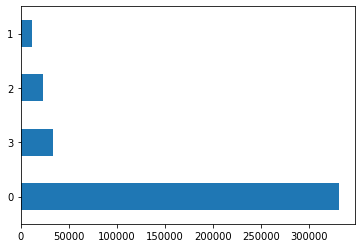

In [28]:
df['UsageBand'].value_counts().plot.barh()

Essas funções aplicaram as transformações para todas as variáveis:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  float64
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 401125 non-null  int8   
 9   fiModelDesc               401125 non-null  int16  
 10  fiBaseModel               401125 non-null  int16  
 11  fiSecondaryDesc           401125 non-null  int16  
 12  fiModelSeries             401125 non-null  int8   
 13  fiModelDescriptor         401125 non-null  i

## Valores ausentes

Alguns algoritmos de treinamento vão gerar erros quando tentamos passar valores ausentes. Podemos verificar valores ausentes utilizando o pandas.:

Já corrigimos os valores ausentes nas variáveis categóricas/texto. Como podemos fazer nas numéricas?

In [30]:
(100*df.isnull().sum()/df.shape[0]).sort_values(ascending=False)

MachineHoursCurrentMeter    64.408850
auctioneerID                 5.019882
SalesID                      0.000000
Undercarriage_Pad_Width      0.000000
Backhoe_Mounting             0.000000
                              ...    
Blade_Width                  0.000000
Enclosure_Type               0.000000
Engine_Horsepower            0.000000
Hydraulics                   0.000000
saleElapsed                  0.000000
Length: 65, dtype: float64

Uma abordagem simplificada é imputar os valores ausentes (com a mediana das observações, por exemplo)

In [31]:
for n,c in df.items():
    fix_missing(df,c,n)

Aqui, se quisermos ter um cuidado extra, poderiamos primeiramente ter separado uma seção dos dados para a validação. Com isso aplicariamos as medianas calculadas <b> com base nos dados de treinamento </b>. Não vamos fazer isso por enquanto, mas lembre-se: sempre que você fizer um pré-processamento, será que está "colando" informações da validação?

## Criando um checkpoint

Fizemos vários processamentos, seria interessante criar um checkpoint salvando nossa base de dados, não? Aqui vamos usar um formato mais rápido e mais compacto para as leituras e escritas:

In [ ]:
!pip install pyarrow #permite salvar em formatos tipo .parquet ou .feather

In [32]:
%time df.to_feather('../data/01_checkpoint_df_processed.feather')

Wall time: 120 ms


# E finalmente..vamos treinar um modelo

In [33]:
%time df = pd.read_feather('../data/01_checkpoint_df_processed.feather')

Wall time: 46.9 ms


A sintaxe é muito parecida com a do Linear regressor

In [34]:
modelo = RandomForestRegressor(n_jobs=-1, random_state=10)

In [35]:
features = [x for x in df.columns if x != 'SalePrice']

In [36]:
output = 'SalePrice'

In [37]:
%time modelo.fit(X=df[features],y=df[output])

Wall time: 3min 41s


RandomForestRegressor(n_jobs=-1, random_state=10)

In [38]:
modelo.score(X=df[features], y=df[output])

0.988166718938969

<b> <font color='red'> Será que é plausível afirmar que o modelo obtido explica 98,8% da variancia do preço de venda? </font></b>

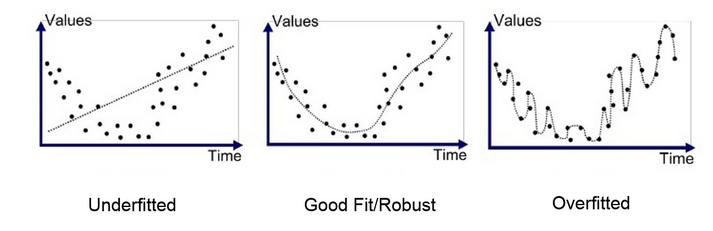

In [39]:
Image('../figures/overfitting.png')

Em machine learning, há um conceito chamado <b> tradeoff entre bias e variância </b>:

O erro de um modelo preditivo pode ser decomposto em:

Erro = erro redutível + erro irredutível (aleatório)

ou:

Erro = Bias + Variância + erro irredutível (aleatório)

- <b> Bias </b>: modelo não consegue capturar a verdadeira relação entre as variáveis. Exemplo: modelo linear aplicado para um fenômeno inerentemente não linear. Nesse caso, normalmente o score do modelo é baixo tanto no treinamento quando nos datasets de validação

- <b> Variância </b>: modelo tende a se ajustar excessivamente a um dataset, memorizando inclusive os erros do mesmo. Isso acaba comprometendo sua capacidade de generalização. Pode ser detectado, por exemplo, quando há uma grande redução no score do modelo ao ser testado em um conjunto de dados diferente do treinamento

Para aprender mais: https://www.machinelearningplus.com/machine-learning/bias-variance-tradeoff/

<b> O tradeoff é:  </b> quando mais complexo o modelo, menor tende a ser seu bias, porém maior a chance de o modelo memorizar o dataset de treino

<b> Lembre-se do problema: </b> dado o conhecimento do histórico de preços de leilão e variáveis associadas às escavadeiras, queremos predizer preços no futuro

Uma forma de fazer validação é com K-fold. Seria adequado usá-lo aqui? Por que?

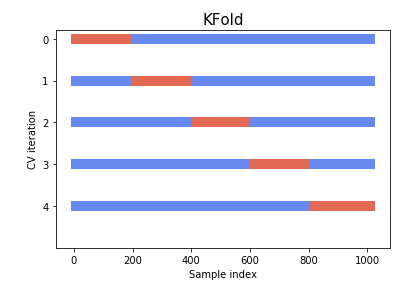

In [40]:
Image('../figures/kfold.png')

Agora vamos separar uma parte da amostragem para utilizar como subset de validação do modelo. no entanto precisamos garantir que o subset de validação seja em datas futuras em relação ao subset de treinamento

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
df.shape

(401125, 67)

In [43]:
#a coluna saledate foi eliminada no processamento de features de datas
df['saledate'] = pd.to_datetime(df[['saleYear', 'saleMonth', 'saleDay']].rename(
    columns={
        'saleYear': 'year', 
        'saleMonth': 'month', 
        'saleDay': 'day'
    }
))

In [44]:
df = df.sort_values(by='saledate', ascending=True)

O índice não traz informação relevante nesse caso:

In [45]:
df = df.reset_index(drop=True) 

In [46]:
train, validation = train_test_split(df, test_size=0.05, shuffle=False)

In [47]:
train.shape

(381068, 68)

In [48]:
validation.shape

(20057, 68)

In [49]:
train

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,saledate
0,1646770,9.159047,1126363,8434,132,18.0,1974,0.0,0,4537,...,False,False,False,False,False,False,600998400,False,True,1989-01-17
1,1404019,10.085809,1169900,7110,132,99.0,1986,0.0,0,735,...,True,False,False,False,False,False,602208000,False,True,1989-01-31
2,1415646,10.463103,1262088,3357,132,99.0,1975,0.0,0,82,...,True,False,False,False,False,False,602208000,False,True,1989-01-31
3,1596358,9.852194,1433229,8247,132,99.0,1978,0.0,0,1158,...,True,False,False,False,False,False,602208000,False,True,1989-01-31
4,1821514,9.546813,1194089,10150,132,99.0,1980,0.0,0,1800,...,True,False,False,False,False,False,602208000,False,True,1989-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381063,4366787,10.308953,2267735,5434,172,1.0,1996,10845.0,3,620,...,False,False,False,False,False,False,1307059200,False,False,2011-06-03
381064,1689330,10.571317,1520406,11618,132,1.0,1998,13167.0,3,2690,...,False,False,False,False,False,False,1307059200,False,False,2011-06-03
381065,4367163,11.184421,2289586,17011,172,1.0,2008,4892.0,1,260,...,False,False,False,False,False,False,1307059200,False,False,2011-06-03
381066,4367164,11.191342,2293829,17015,172,1.0,2007,5913.0,1,362,...,False,False,False,False,False,False,1307059200,False,False,2011-06-03


Ao longo do código, podemos usar as afirmações para checar e garantir que a lógica que queremos implementar é de fato o que está acontecendo 

In [50]:
assert df.shape[0] == train.shape[0] + validation.shape[0], 'Oops, algo de errado não está certo. A soma não está batendo.'

Se falharmos em dividir corretamente nosso dataset, as chances de overfitting são grandes, então vamos colocar uma segurança aqui:

In [51]:
assert validation.saledate.min() >= train.saledate.max() #nesse caso >= porque a data está em dias

In [52]:
modelo = RandomForestRegressor(n_jobs=-1, random_state=10)

In [45]:
%time modelo.fit(X=train[features], y=train[output])

Wall time: 3min 50s


RandomForestRegressor(n_jobs=-1, random_state=10)

In [46]:
modelo.score(train[features], train[output])

0.9880155011264475

In [56]:
modelo.score(validation[features], validation[output])

0.8792206070725614

In [54]:
import pickle #biblioteca para serializar objetos python

In [53]:
#with é um gerenciador de contexto. A vantagem é que não precisamos explicitamente fazer file.close(). 
#quando saimos do bloco indentado por with, o "file" é automaticamente fechado
#wb: significa write binary
with open('../models/rf_v1.pkl', 'wb') as file: 
    pickle.dump(modelo, file, protocol = pickle.HIGHEST_PROTOCOL) # é o ultimo protocolo. ajuda no tamanho mas pode ser incompativel com versões anteriores

In [55]:
with open('../models/rf_v1.pkl', 'rb') as file:
    modelo = pickle.load(file)

Ok! Agora estamos testando o desempenho do modelo em um segmento que o processo de treinamento nunca viu. Podemos usar essa informação para entender se o modelo está generalizando bem. 

Mas...continua muito lento, não? Como vamos fazer vários experimentos se cada rodada de treino leva muitos minutos? 

Poderiamos  pensar em fazer uma amostragem aleatória desses dados de treinamento, dessa forma reduziriamos o risco de overfitting, o treinamento seria mais rápido. E se observações cruciais para a performance do modelo não forem selecionadas? Vamos falar de uma alternativa bem interessante logo mais

# Entendendo o RandomForest

Uma floresta é feita de...árvores! Nesse caso árvores de decisão, também conhecidas no sklearn como estimadores:

In [57]:
modelo.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=1165313289),
 DecisionTreeRegressor(max_features='auto', random_state=1283169405),
 DecisionTreeRegressor(max_features='auto', random_state=89128932),
 DecisionTreeRegressor(max_features='auto', random_state=2124247567),
 DecisionTreeRegressor(max_features='auto', random_state=574014784),
 DecisionTreeRegressor(max_features='auto', random_state=1902734705),
 DecisionTreeRegressor(max_features='auto', random_state=1068604539),
 DecisionTreeRegressor(max_features='auto', random_state=1425548444),
 DecisionTreeRegressor(max_features='auto', random_state=2141071321),
 DecisionTreeRegressor(max_features='auto', random_state=357864157),
 DecisionTreeRegressor(max_features='auto', random_state=965494256),
 DecisionTreeRegressor(max_features='auto', random_state=108111773),
 DecisionTreeRegressor(max_features='auto', random_state=850673521),
 DecisionTreeRegressor(max_features='auto', random_state=898541562),
 DecisionTreeRegressor(max_f

In [56]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

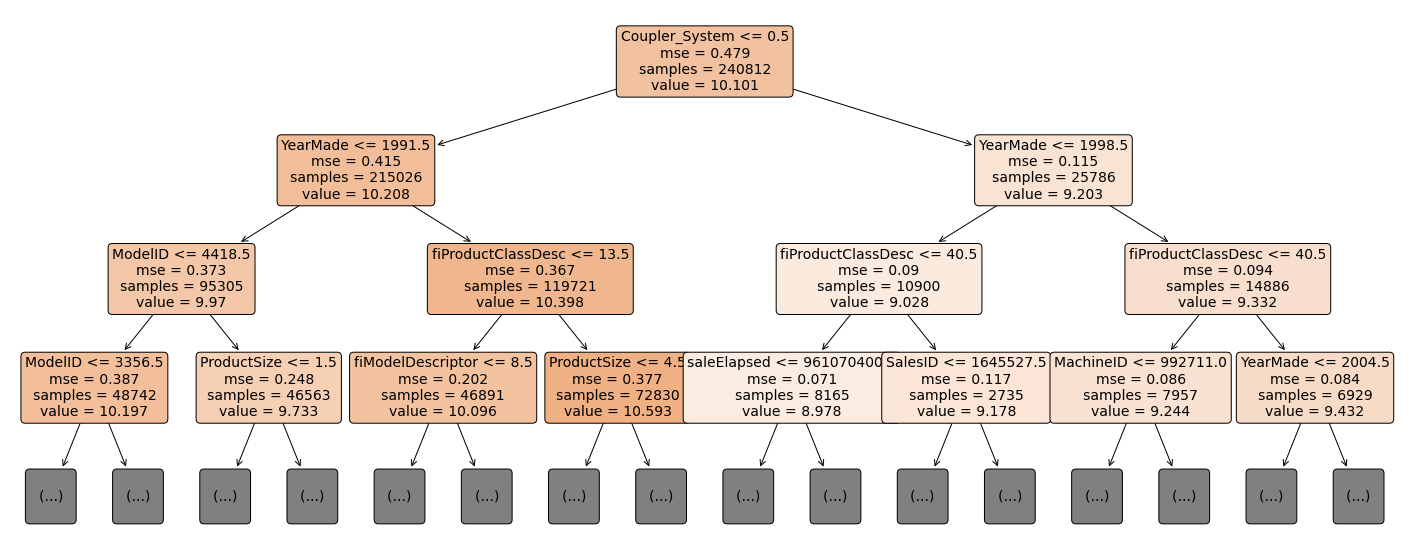

In [57]:
plt.figure(figsize=(25,10))
a = plot_tree(modelo.estimators_[0], 
              feature_names=features, 
              filled=True, 
              rounded=True, 
              fontsize=14,
              max_depth=3
             )

Podemos avaliar o poder preditivo de uma das árvores:

In [87]:
from sklearn.metrics import r2_score

In [88]:
ypred_arvore = modelo.estimators_[1].predict(X=validation[features])

In [89]:
r2_score(validation[output], ypred_arvore)

0.7242878304229943

Se cada árvore nos dá um número...que tal se a nossa predição for a média de todas?

In [90]:
predicoes = {}
k=1
for arvore in modelo.estimators_:   
    print(f"predizendo com árvore {k}")
    predicoes[f"arvore_{k}"] = arvore.predict(X=validation[features])
    k+=1

predizendo com árvore 1
predizendo com árvore 2
predizendo com árvore 3
predizendo com árvore 4
predizendo com árvore 5
predizendo com árvore 6
predizendo com árvore 7
predizendo com árvore 8
predizendo com árvore 9
predizendo com árvore 10
predizendo com árvore 11
predizendo com árvore 12
predizendo com árvore 13
predizendo com árvore 14
predizendo com árvore 15
predizendo com árvore 16
predizendo com árvore 17
predizendo com árvore 18
predizendo com árvore 19
predizendo com árvore 20
predizendo com árvore 21
predizendo com árvore 22
predizendo com árvore 23
predizendo com árvore 24
predizendo com árvore 25
predizendo com árvore 26
predizendo com árvore 27
predizendo com árvore 28
predizendo com árvore 29
predizendo com árvore 30
predizendo com árvore 31
predizendo com árvore 32
predizendo com árvore 33
predizendo com árvore 34
predizendo com árvore 35
predizendo com árvore 36
predizendo com árvore 37
predizendo com árvore 38
predizendo com árvore 39
predizendo com árvore 40
predizend

In [91]:
predicoes = pd.DataFrame(predicoes)

In [92]:
predicoes.mean(axis=1) #media das colunas para cada linha. Para saber mais, entenda o argumento axis 0 ou 1

0         9.638360
1         9.709883
2         9.415383
3         9.769776
4        10.100970
           ...    
20052     9.563613
20053     9.513101
20054     9.389584
20055     9.995806
20056     9.343254
Length: 20057, dtype: float64

In [93]:
predicoes['media_das_arvores'] = predicoes.mean(axis=1) 

In [94]:
r2_score(validation[output], predicoes['media_das_arvores'])

0.8792206070725613

<b> Para pensar: </b> se todas as árvores tem r² mediocre, por que a média delas dá um resultado muito melhor?

## Bagging

A resposta da pergunta acima é: <font color='green'>  <b> sabedoria das massas! </b> </font>. Existe um conceito chamado:

<b> Bagging = Bootstrap + Aggregating </b>

A ideia é a seguinte:

- se tivermos vários modelos medíocres, que tenham um baixo poder preditivo, e se esses modelos forem descorrelacionados entre si, os erros dos modelos (árvores) tendem a cancelar entre si e gerar um agregado (ensemble) com erro mínimo.

- para essa idéia funcionar, não adianta criar as mesmas árvores, é necessário que os modelos sejam descorrelacionados 

Para aprender mais:

https://www.kdnuggets.com/2021/05/ensemble-methods-explained-plain-english-bagging.html

Como produzir árvores descorrelacionadas entre si? <font color='blue'> <b>  Introduzindo aleatoriedade! </b> </font> . Isso pode ser feito com o bootstrapping, é uma técnica poderosa que consiste basicamente em fazer muitas amostragens aleatórias com reposição

In [95]:
train.shape

(381068, 68)

In [96]:
modelo = RandomForestRegressor(max_samples=40000, n_estimators=30, n_jobs=-1, random_state=10) #para cada árvore, esse número de amostras será sorteado do train-set original

In [97]:
%time modelo.fit(X=train[features], y=train[output])

Wall time: 11.8 s


RandomForestRegressor(max_samples=40000, n_estimators=30, n_jobs=-1,
                      random_state=10)

In [99]:
modelo.score(validation[features], validation[output])

0.8632769462859775

Observe que o tempo de treino caiu bastante e o r² continua muito próximo ao modelo original

   ## Principais parâmetros que podem ser ajustados

Diferente do modelo de regressão linear que vimos, aqui temos parâmetros que não são diretamente ajustados no treino. Eles são chamados de <b> hiperparâmetros </b>

In [58]:
modelo = RandomForestRegressor(
    n_estimators=30, #número de árvores
    n_jobs=-1, #usar todos os núcleos do processador disponíveis
    min_samples_leaf=3, #evita de fazer mais partições na árvore até isolar cada amostra. Menos overfitting, menos volatilidade e mais velocidade
    max_samples=40000, #aleatóriedade: cada árvore ira ajustar em um pedaço diferente do dataset
    max_features= 0.8, #mais aleatoriedade: em cada nó de decisão de uma árvore, 80% das variáveis são sorteadas e só elas podem ser usadas 
    random_state = 10, #pode ser qualquer número. Irá gerar sempre o mesmo sorteio aleatório
    oob_score=True #métrica de validação de graça :)
)

In [59]:
%time modelo.fit(X=train[features], y=train[output])

Wall time: 16.6 s


RandomForestRegressor(max_features=0.8, max_samples=40000, min_samples_leaf=3,
                      n_estimators=30, n_jobs=-1, oob_score=True,
                      random_state=10)

In [60]:
modelo.score(validation[features], validation[output])

0.8722626390519617

Mudamos vários parâmetros, o treinamento agora está mais rápido e o score de validação continua no mesmo patamar. Como escolher esses parâmetros? 

# Ajustando hiperparâmetros

Podemos pensar em vários aspectos para tentar decidir quais são os hiperparâmetros ótimos:

- risco de overfitting
- número de amostras do dataset
- tempo de treinamento
- necessidade de mais performance

Na prática, podemos experimentar. Podemos testar várias combinações de hiperparâmetros e entender qual seu desempenho na validação

In [61]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit, TimeSeriesSplit

Dois métodos:

- grid search - definimos várias combinações e testamos todas elas. Força bruta!
- random search - definimos várias combinações, amostramos N delas e testamos

In [62]:
parametros_para_testar = {
    'n_estimators': [20, 50, 100],
    'min_samples_leaf': [1, 3, 5],
    'max_samples': [40000],
    'oob_score': [True],
    'max_features': [0.5, 0.8, 1],
    'n_jobs': [-1],
}

Criando uma estratégia de CV (cross-validation) personalizada que irá no argumento cv (cross-validation):

In [63]:
class SplitterPersonalizado():    
    
    def __init__(self, test_size=0.1):
        self.n_splits = 1
        self.test_size = test_size
                
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):  
        train, validation = train_test_split(X, test_size=self.test_size, shuffle=False)
        yield train.index, validation.index

In [106]:
grid = GridSearchCV(
    estimator = RandomForestRegressor(), 
    param_grid = parametros_para_testar,
    n_jobs=-1,
    cv = SplitterPersonalizado(), #especificar a estratégia de validação cruzada
    verbose=1
)

Obs: existem várias estratégias de cv prontas, por exemplo o KFold(), TimeSeriesSplit(), etc. O intuito é mostrar que podemos criar a nossa própria estratégia personalizada.

<b> Lembre-se </b>: a maior parte das estratégias fazem uma amostragem aleatória para compor o treino e validação. Se o problema que você está tentando resolver tem um componente tempo, i.e., precisamos medir a capacidade do modelo em predizer num periodo futuro, esse tipo de estratégia é inadequada!

In [ ]:
%time grid.fit(X=df[features], y=df[output])

<b> Dica: </b> podemos salvar um objeto python, nesse caso um modelo que demorou vários minutos para ser treinado. Dessa forma quando abrirmos novamente o notebook é possivel carregá-lo de um arquivo diretamente:

In [140]:
import pickle #biblioteca para serializar objetos python

#with é um gerenciador de contexto. A vantagem é que não precisamos explicitamente fazer file.close(). 
#quando saimos do bloco indentado por with, o "file" é automaticamente fechado
#wb: significa write binary
with open('../models/grid_search_rf.pkl', 'wb') as file: 
    pickle.dump(grid, file, protocol=-1)

Carregando um arquivo serializado:

In [65]:
with open('../models/grid_search_rf.pkl', 'rb') as file:
    grid = pickle.load(file)

In [66]:
grid.best_index_

4

In [67]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_samples,param_min_samples_leaf,param_n_estimators,param_n_jobs,param_oob_score,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,68.650213,0.0,3.549414,0.0,0.5,40000,1,20,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.858619,0.858619,0.0,16
1,132.857711,0.0,2.555014,0.0,0.5,40000,1,50,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.864321,0.864321,0.0,9
2,232.268334,0.0,4.816048,0.0,0.5,40000,1,100,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.866069,0.866069,0.0,3
3,66.939200,0.0,3.462884,0.0,0.5,40000,3,20,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.861172,0.861172,0.0,13
4,124.169237,0.0,4.275026,0.0,0.5,40000,3,50,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.867223,0.867223,0.0,1
5,208.654983,0.0,6.291614,0.0,0.5,40000,3,100,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.866290,0.866290,0.0,2
6,67.600207,0.0,3.432885,0.0,0.5,40000,5,20,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.857979,0.857979,0.0,18
7,116.152619,0.0,4.217078,0.0,0.5,40000,5,50,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.863080,0.863080,0.0,10
8,178.032029,0.0,4.759312,0.0,0.5,40000,5,100,-1,True,"{'max_features': 0.5, 'max_samples': 40000, 'm...",0.864526,0.864526,0.0,7
9,60.795086,0.0,2.486009,0.0,0.8,40000,1,20,-1,True,"{'max_features': 0.8, 'max_samples': 40000, 'm...",0.859472,0.859472,0.0,14


Para fazer uma busca aleatória, o procedimento é muito parecido. Precisamos especificar o número de combinações que queremos testar:

In [ ]:
grid = RandomizedSearchCV(
    estimator = RandomForestRegressor(), 
    param_grid = parametros_para_testar,
    n_iter = 15 #testar 15 combinações
    n_jobs=-1,
    cv = SplitterPersonalizado(), #especificar a estratégia de validação cruzada
    verbose=1
)

# Como podemos melhorar o modelo? 

Vamos começar entendendo como ele usa as variáveis para gerar as predições

Utilizando os parâmetros otimos encontrados:

In [68]:
rf_pars = grid.best_params_

In [69]:
rf_pars

{'max_features': 0.5,
 'max_samples': 40000,
 'min_samples_leaf': 3,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': True}

In [70]:
modelo = RandomForestRegressor(**rf_pars)
%time modelo.fit(train[features], train[output])

Wall time: 20.4 s


RandomForestRegressor(max_features=0.5, max_samples=40000, min_samples_leaf=3,
                      n_estimators=50, n_jobs=-1, oob_score=True)

In [71]:
#criando uma função utilitária para gerar o score dos modelos
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def score_model(
    train: pd.DataFrame, 
    valid: pd.DataFrame,
    features: list, 
    output: str, 
    model: RandomForestRegressor
) -> pd.DataFrame:

    """
    calcula métricas do modelo
    
    Parameters:
    -----------
    
    train: dataframe com as observações de treinamento
    valid: dataframe com as observações para validação
    feature: lista das variáveis preditoras do modelo
    output: nome da variável resposta do modelo
    model: objeto regressor já treinado
    
    Returns:
    --------
    
    tabela contendo os resultados de treino, validação e oob_score (se tiver no modelo)
    
    """
    
    ypred_train = model.predict(train[features])
    yreal_train = train[output]

    ypred_valid = model.predict(valid[features])
    yreal_valid = valid[output]
    
    
    scorer_funcs = [mean_squared_error, mean_absolute_error, r2_score]
    
    scores = {}
    for f in scorer_funcs:  
        scores[f"{f.__name__}_train"] = round(f(yreal_train, ypred_train),3)
        scores[f"{f.__name__}_valid"] = round(f(yreal_valid, ypred_valid),3)
        
        if f == mean_squared_error:
            scores[f"rmse_train"] = round(np.sqrt(scores[f"{f.__name__}_train"]),3)
            scores[f"rmse_valid"] = round(np.sqrt(scores[f"{f.__name__}_valid"]),3)
    
    if hasattr(model, 'oob_score_'):
        scores['oob'] = round(model.oob_score_,3)
    
    return scores

In [72]:
score_model(train, validation, features, output, modelo)

{'mean_squared_error_train': 0.045,
 'mean_squared_error_valid': 0.066,
 'rmse_train': 0.212,
 'rmse_valid': 0.257,
 'mean_absolute_error_train': 0.154,
 'mean_absolute_error_valid': 0.194,
 'r2_score_train': 0.906,
 'r2_score_valid': 0.872,
 'oob': 0.892}

## Feature importance

Os modelos baseados em árvores tem uma funcionalidade muito interessante:

In [73]:
modelo.feature_importances_ #são dados na mesma ordem das variáveis preditoras especificadas (em features, nesse caso)

array([2.81805500e-02, 2.14502805e-02, 5.26032691e-02, 9.70387426e-04,
       3.82747355e-03, 1.70327616e-01, 2.23127265e-03, 7.88014489e-04,
       3.11401217e-02, 2.05565975e-02, 4.24086857e-02, 4.21089419e-03,
       2.45237074e-02, 1.00100710e-01, 7.27631535e-02, 6.60590682e-03,
       5.27579080e-03, 9.24650513e-03, 8.61789337e-03, 4.09399385e-02,
       5.77795820e-04, 2.03785118e-04, 4.73063727e-04, 3.11378138e-03,
       1.38592150e-03, 1.29153974e-03, 1.33193941e-03, 7.25032024e-04,
       1.08671478e-03, 4.22442495e-04, 1.25620633e-02, 1.42272635e-03,
       3.11983785e-03, 1.39058969e-03, 8.35588584e-04, 4.76918260e-03,
       1.62808919e-03, 1.05501589e-01, 6.12447888e-02, 3.41529368e-02,
       4.71810546e-03, 2.47614722e-03, 4.73873733e-03, 8.91532600e-04,
       8.01043241e-04, 5.09905948e-04, 5.79804660e-04, 3.13077898e-03,
       1.44687400e-03, 2.45867923e-04, 4.61032947e-04, 2.07713289e-02,
       2.51547610e-03, 4.77054964e-03, 6.64919053e-03, 3.37726928e-03,
      

In [74]:
var_imp = pd.DataFrame(list(zip(features, modelo.feature_importances_)), columns=['feature', 'importancia']).sort_values(by='importancia', ascending=False)

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

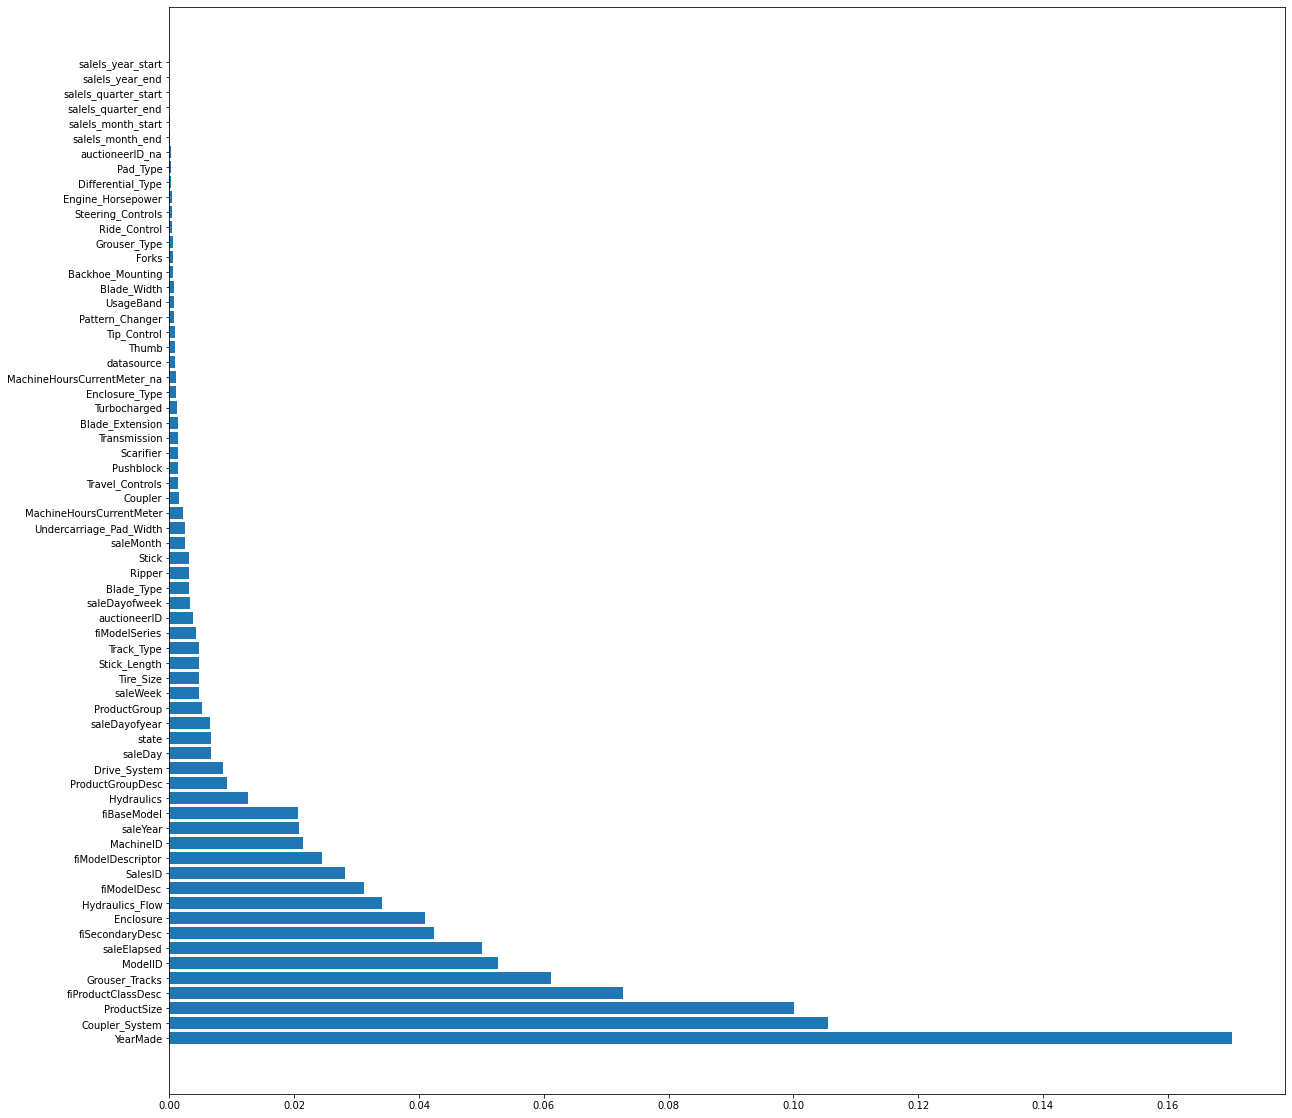

In [76]:
fig, ax = plt.subplots(figsize=(20,20))
ax = ax.barh(var_imp['feature'],var_imp['importancia'])

<b> Como isso é feito?! </b>

## Removendo variáveis pouco importantes

Tentando remover as variáveis com menor importância

In [77]:
threshold = 0.005
var_imp.loc[var_imp['importancia'] < threshold]

,feature,importancia
53,saleWeek,0.004771
35,Tire_Size,0.004769
42,Stick_Length,0.004739
40,Track_Type,0.004718
11,fiModelSeries,0.004211
4,auctioneerID,0.003827
55,saleDayofweek,0.003377
47,Blade_Type,0.003131
32,Ripper,0.003120
23,Stick,0.003114


In [78]:
variaveis_para_excluir = var_imp.loc[var_imp['importancia'] < threshold, 'feature'].tolist()

In [79]:
features_novas = [x for x in features if x not in variaveis_para_excluir]

In [80]:
features_novas

['SalesID',
 'MachineID',
 'ModelID',
 'YearMade',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Hydraulics',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'saleYear',
 'saleDay',
 'saleDayofyear',
 'saleElapsed']

In [81]:
print(f"features originais: {len(features)}, features novas: {len(features_novas)}")

features originais: 66, features novas: 23


In [82]:
modelo = RandomForestRegressor(**rf_pars)
%time modelo.fit(train[features_novas], train[output])

Wall time: 10.5 s


RandomForestRegressor(max_features=0.5, max_samples=40000, min_samples_leaf=3,
                      n_estimators=50, n_jobs=-1, oob_score=True)

In [83]:
score_model(train, validation, features_novas, output, modelo)

{'mean_squared_error_train': 0.045,
 'mean_squared_error_valid': 0.066,
 'rmse_train': 0.212,
 'rmse_valid': 0.257,
 'mean_absolute_error_train': 0.156,
 'mean_absolute_error_valid': 0.193,
 'r2_score_train': 0.905,
 'r2_score_valid': 0.872,
 'oob': 0.891}

## Identificando preditores correlacionados

Diferente de um modelo linear, preditores correlacionados num modelo baseado em árvores de decisão não irá penalizar sua performance a ponto de torná-lo inválido. <b> No entanto, colinearidades distorcem a real importância de seus preditores </b>

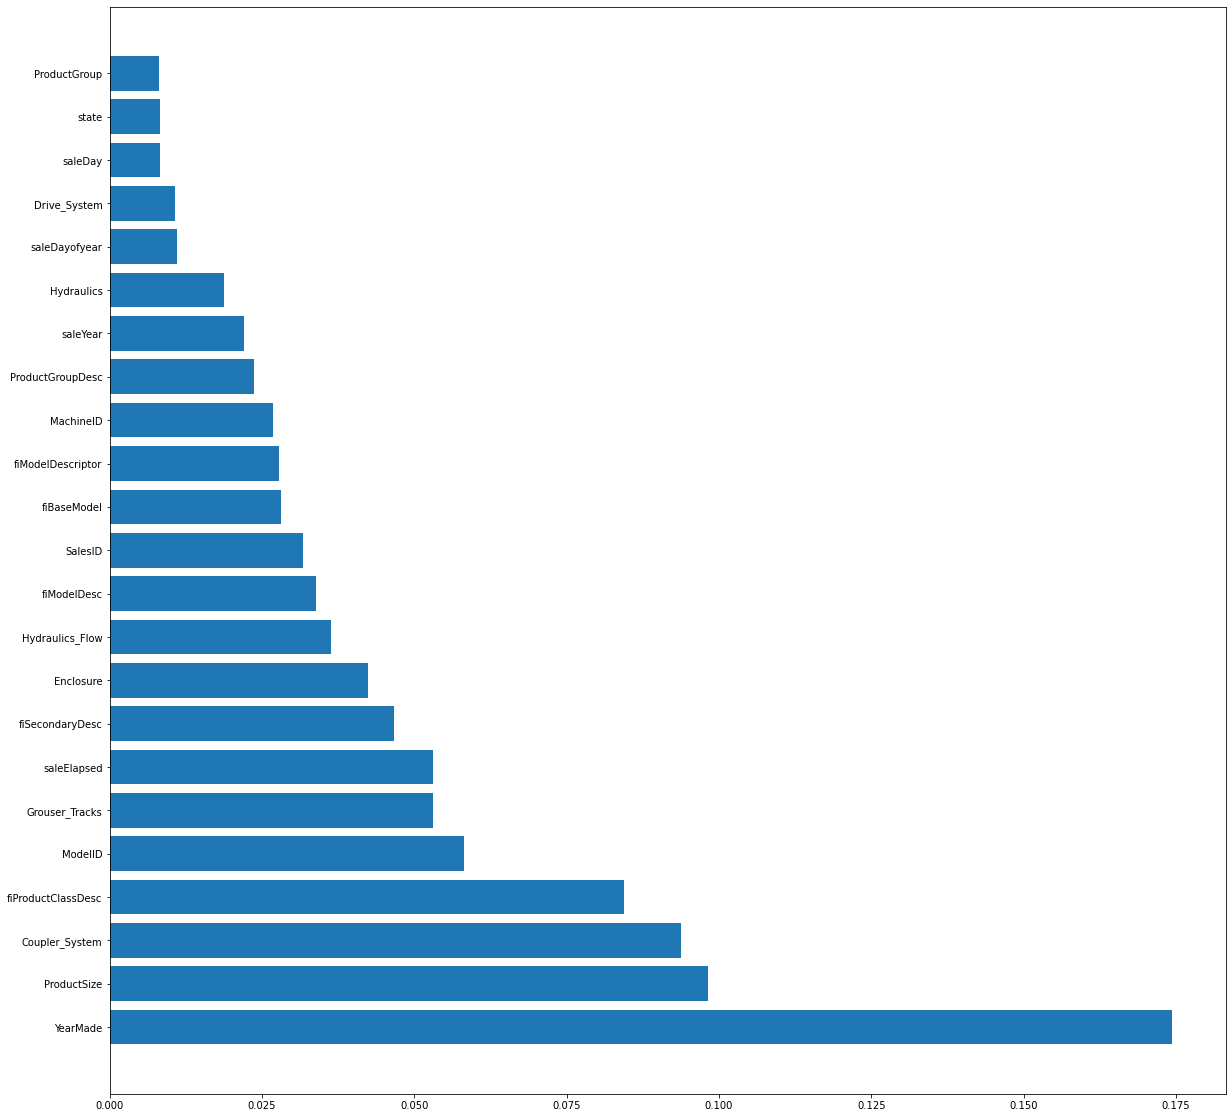

In [84]:
var_imp = pd.DataFrame(list(zip(features_novas, modelo.feature_importances_)), columns=['feature', 'importancia']).sort_values(by='importancia', ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
ax = ax.barh(var_imp['feature'],var_imp['importancia'])

Podemos inspecionar o coeficiente de correlação e tentar eliminar variáveis redundantes:

In [85]:
sns.set_theme(style="white")

In [86]:
upp_mat = np.triu(train[features_novas].corr())

<AxesSubplot:>

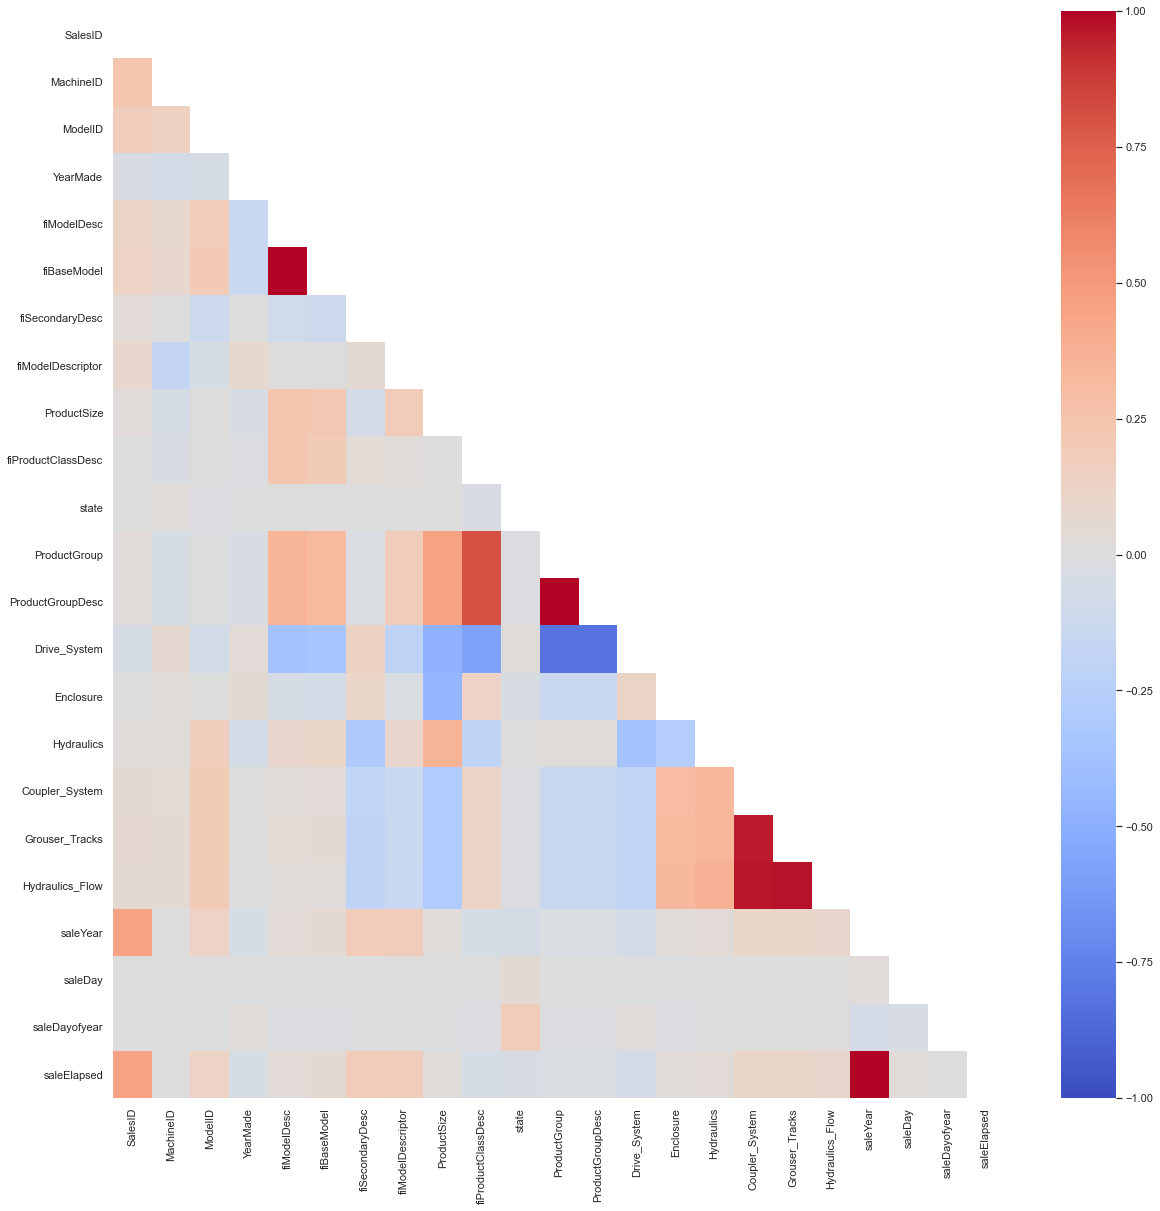

In [87]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(train[features_novas].corr(), vmin = -1, vmax = +1, annot = False, cmap = 'coolwarm', mask = upp_mat)

<b> Lembre-se: </b> correlação não é causalidade, mas pode ser uma bússola para nos direcionar quais variáveis devemos entender melhor o efeito

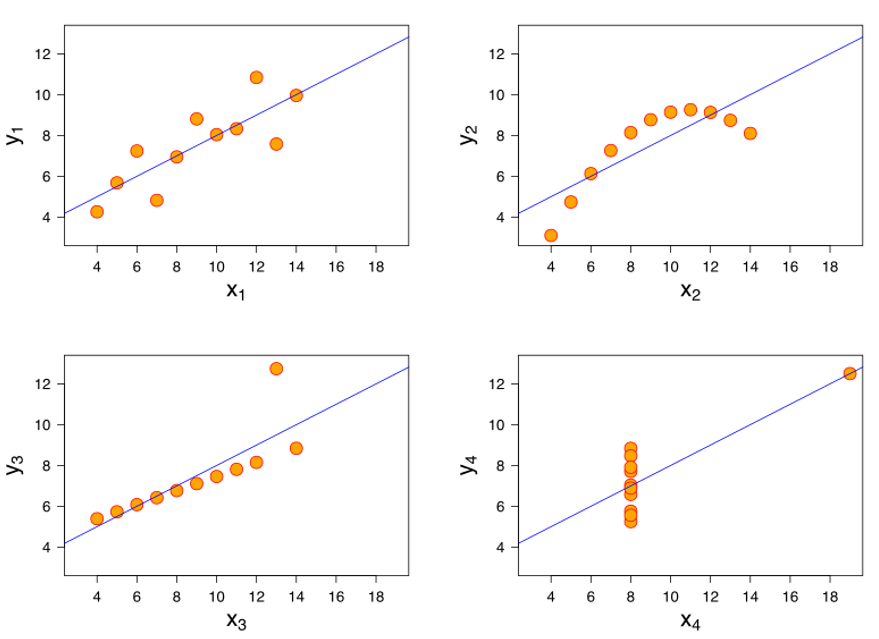

In [88]:
Image('../figures/quarteto_ascombe.png')

Outra forma de verificar a correlação é criando um gráfico de clusterização: nele, a distância entre duas variáveis é o inverso da correlação. Note que aqui usamos a correlação de spearman (não linear)

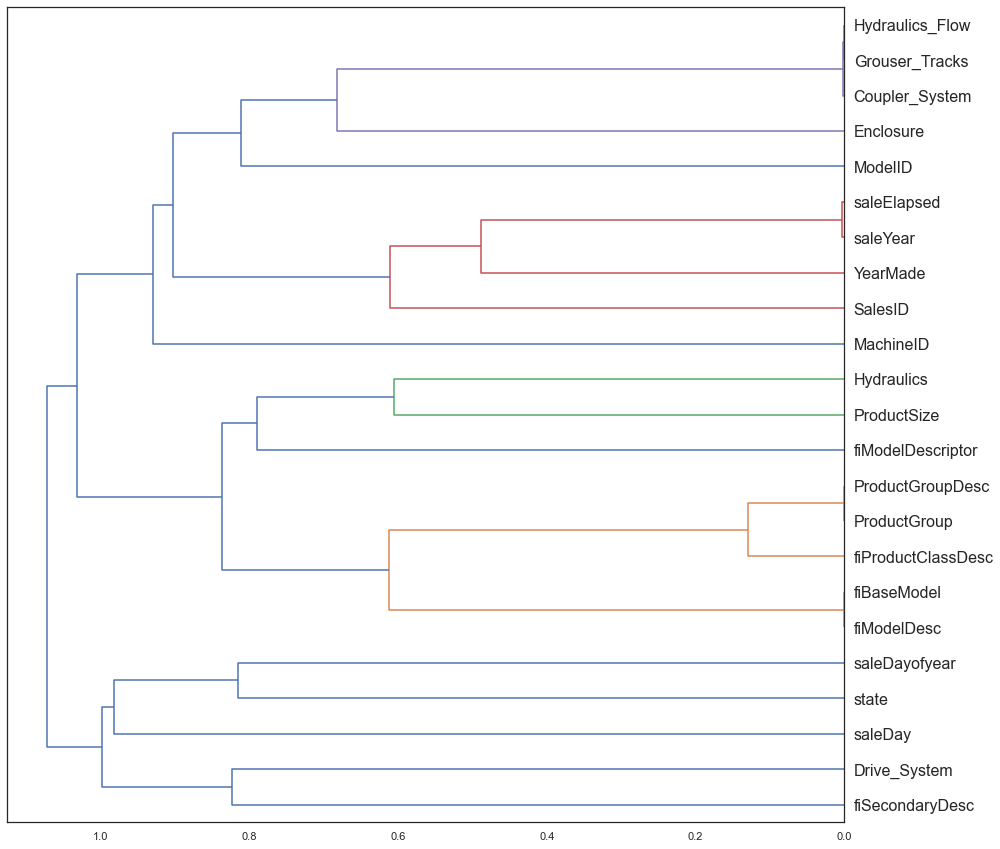

In [89]:
from scipy.stats import spearmanr
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt

corr = np.round(spearmanr(train[features_novas]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(15,15))
dendogram = hc.dendrogram(z, labels=features_novas, orientation='left', leaf_font_size=16)
plt.show()

Se as variáveis mais próximas são redundantes, tirar uma delas não deveria afetar o modelo, certo? Como podemos descobrir? Testando!

In [90]:
variaveis_correlacionadas_para_remover = [
    'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System',
    'SaleElapsed', 'SaleYear',
    'fiBaseModel', 'fiModelDesc'
]

In [92]:
resultado = {}
for var in variaveis_correlacionadas_para_remover:
    print(f"removendo {var}")
    modelo = RandomForestRegressor(**rf_pars)
    
    feats = [x for x in features_novas if x!= var]
    
    modelo.fit(train[feats], train[output])
    resultado[f"removendo_{var}"] = score_model(train, validation, feats, output, modelo)

removendo Hydraulics_Flow
removendo Grouser_Tracks
removendo Coupler_System
removendo SaleElapsed
removendo SaleYear
removendo fiBaseModel
removendo fiModelDesc


In [93]:
pd.DataFrame(resultado).T[['rmse_valid', 'r2_score_valid']]

,rmse_valid,r2_score_valid
removendo_Hydraulics_Flow,0.253,0.874
removendo_Grouser_Tracks,0.253,0.874
removendo_Coupler_System,0.255,0.874
removendo_SaleElapsed,0.253,0.874
removendo_SaleYear,0.255,0.873
removendo_fiBaseModel,0.257,0.872
removendo_fiModelDesc,0.257,0.870


Vamos remover as variáveis que foram testadas, e, na sua ausência, melhoraram o modelo

In [94]:
vars_remover = ['Hydraulics_Flow', 'SaleElapsed']

In [95]:
features_novas = [x for x in features_novas if x not in vars_remover]

In [96]:
len(features_novas)

22

Retreinando o modelo sem algumas variáveis redundantes:

In [97]:
modelo = RandomForestRegressor(**rf_pars)
%time modelo.fit(train[features_novas], train[output])

Wall time: 10 s


RandomForestRegressor(max_features=0.5, max_samples=40000, min_samples_leaf=3,
                      n_estimators=50, n_jobs=-1, oob_score=True)

In [98]:
score_model(train, validation, features_novas, output, modelo)

{'mean_squared_error_train': 0.045,
 'mean_squared_error_valid': 0.065,
 'rmse_train': 0.212,
 'rmse_valid': 0.255,
 'mean_absolute_error_train': 0.155,
 'mean_absolute_error_valid': 0.192,
 'r2_score_train': 0.906,
 'r2_score_valid': 0.873,
 'oob': 0.892}

O erro parece ter reduzido um pouco eliminando algumas variáveis redundantes. Nesse processo de feature selection envolve modelagem e exploração de dados, é altamente iterativo e precisa ser feito com cautela para não removermos variáveis que trazem informações essenciais ao modelo. 

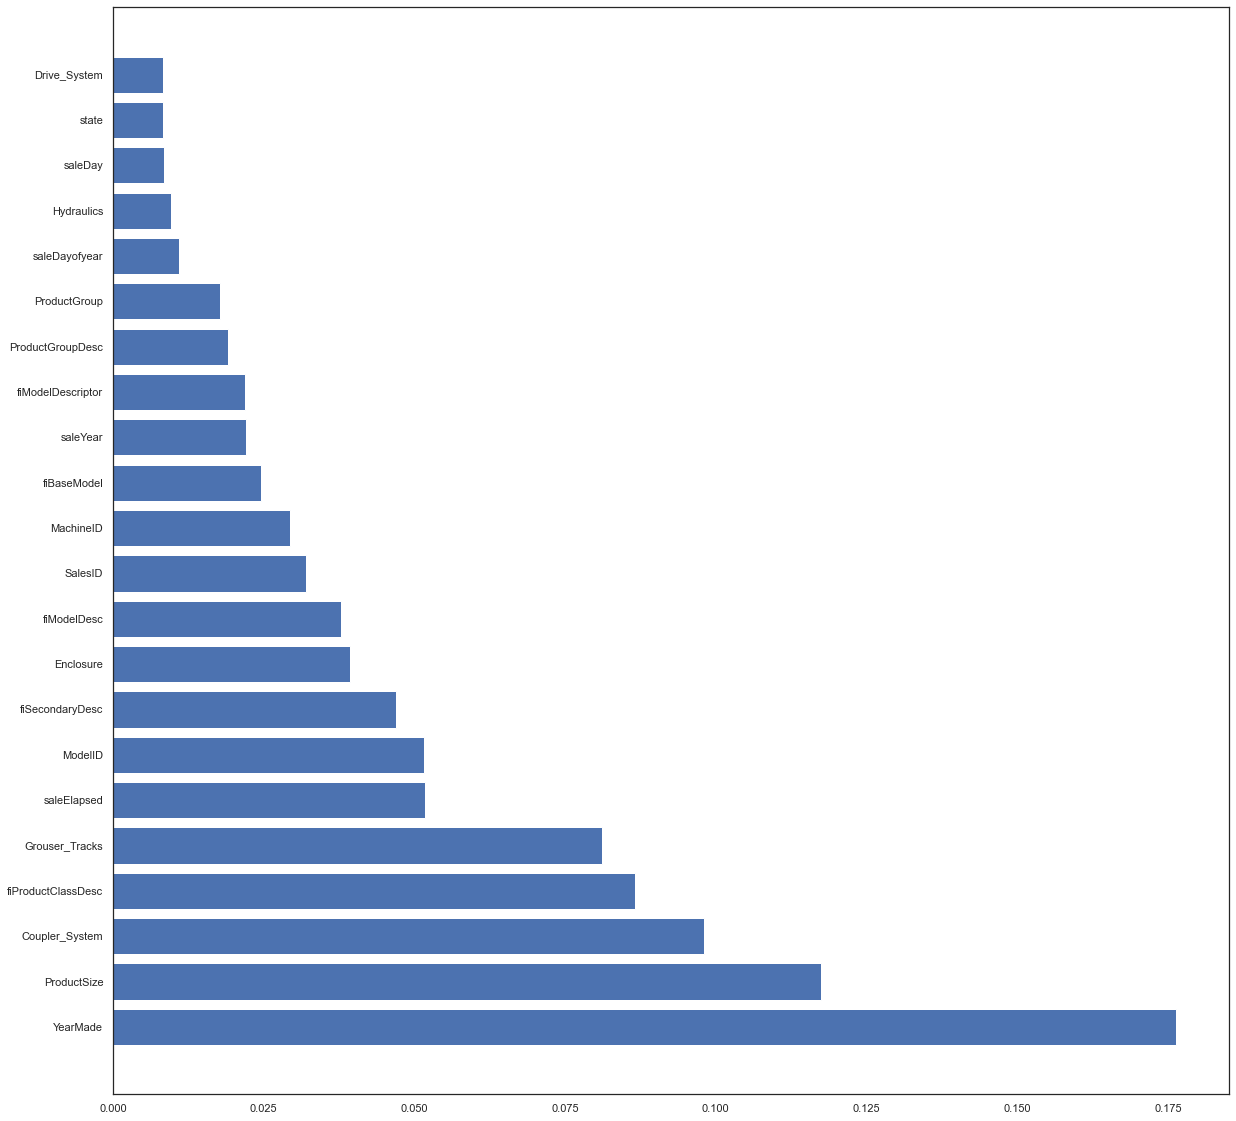

In [99]:
var_imp = pd.DataFrame(list(zip(features_novas, modelo.feature_importances_)), columns=['feature', 'importancia']).sort_values(by='importancia', ascending=False)
fig, ax = plt.subplots(figsize=(20,20))
ax = ax.barh(var_imp['feature'],var_imp['importancia'])

In [100]:
threshold = 0.02
var_imp.loc[var_imp['importancia'] < threshold]

,feature,importancia
12,ProductGroupDesc,0.019146
11,ProductGroup,0.017812
20,saleDayofyear,0.011010
15,Hydraulics,0.009687
19,saleDay,0.008443
10,state,0.008380
13,Drive_System,0.008251


In [101]:
variaveis_para_excluir = var_imp.loc[var_imp['importancia'] < threshold, 'feature'].tolist()

In [102]:
features_mais_filtradas = [x for x in features_novas if x not in variaveis_para_excluir]

In [103]:
len(features_mais_filtradas)

15

In [104]:
modelo = RandomForestRegressor(**rf_pars)
%time modelo.fit(train[features_mais_filtradas], train[output])

Wall time: 9.39 s


RandomForestRegressor(max_features=0.5, max_samples=40000, min_samples_leaf=3,
                      n_estimators=50, n_jobs=-1, oob_score=True)

In [105]:
score_model(train, validation, features_mais_filtradas, output, modelo)

{'mean_squared_error_train': 0.046,
 'mean_squared_error_valid': 0.062,
 'rmse_train': 0.214,
 'rmse_valid': 0.249,
 'mean_absolute_error_train': 0.158,
 'mean_absolute_error_valid': 0.188,
 'r2_score_train': 0.904,
 'r2_score_valid': 0.878,
 'oob': 0.891}

Vamos retreinar o modelo com todas as amostras:

In [106]:
rf_pars = {
    'max_features': 0.5,
    #'max_samples': 40000,
    'min_samples_leaf': 3,
    'n_estimators': 50,
    'n_jobs': -1,
    'oob_score': True
}

In [107]:
modelo = RandomForestRegressor(**rf_pars)
%time modelo.fit(train[features_mais_filtradas], train[output])

Wall time: 27.8 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=50,
                      n_jobs=-1, oob_score=True)

In [108]:
score_model(train, validation, features_mais_filtradas, output, modelo)

{'mean_squared_error_train': 0.019,
 'mean_squared_error_valid': 0.056,
 'rmse_train': 0.138,
 'rmse_valid': 0.237,
 'mean_absolute_error_train': 0.098,
 'mean_absolute_error_valid': 0.177,
 'r2_score_train': 0.961,
 'r2_score_valid': 0.89,
 'oob': 0.907}

In [109]:
features_mais_filtradas

['SalesID',
 'MachineID',
 'ModelID',
 'YearMade',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'Enclosure',
 'Coupler_System',
 'Grouser_Tracks',
 'saleYear',
 'saleElapsed']

Vamos salvar uma versão desse modelo melhorado

In [110]:
with open('../models/rf_v2.pkl', 'wb') as file:
    pickle.dump(modelo, file, protocol=-1)

Também vamos salvar as features usadas:

In [111]:
pd.DataFrame(features_mais_filtradas).to_csv('../models/features_rf_v2.csv', header=False, index=False)

Outras ideias para melhorar seu modelo:

- mudar encoding ordinal por one hot encoding
- testar remover mais variáveis
- fazer feature engineering: por exemplo: SaleDate - YearMade = idade do equipamento
- usar o método Boruta para indicar as variáveis que possuem maior potencial preditivo https://pypi.org/project/Boruta/
- testar algum método de feature selection (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)
- avaliar variáveis que possivelmente estão sendo extrapoladas no conjunto de validação

# Extrapolação

Um ponto de atenção muito importante quando falamos em modelos baseados em árvores de decisão é o que acontece com a predição quando o valor de uma variável é maior que o máximo ou menor que o mínimo encontrado no treinamento:

In [5]:
import pickle

In [6]:
with open('../models/rf_v2.pkl', 'rb') as file:
    modelo = pickle.load(file)

In [113]:
features = pd.read_csv('../models/features_rf_v2.csv', header=None)[0].tolist()

In [114]:
train['YearMade'].describe()

count    381068.000000
mean       1898.048965
std         292.834230
min        1000.000000
25%        1984.000000
50%        1995.000000
75%        2000.000000
max        2012.000000
Name: YearMade, dtype: float64

In [115]:
tabela_pred = train.loc[120, features]

In [116]:
tabela_pred['YearMade'] = np.arange(1935, 2050)

In [117]:
tabela_pred = pd.DataFrame(tabela_pred).T

In [118]:
tabela_pred

,SalesID,MachineID,ModelID,YearMade,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelDescriptor,ProductSize,fiProductClassDesc,Enclosure,Coupler_System,Grouser_Tracks,saleYear,saleElapsed
120,1330182,1404144,1526,"[1935, 1936, 1937, 1938, 1939, 1940, 1941, 194...",2096,681,21,71,0,51,6,0,0,1989,602294400


In [119]:
tabela_pred = tabela_pred.explode('YearMade')

In [120]:
ypred = modelo.predict(tabela_pred)

<AxesSubplot:xlabel='YearMade'>

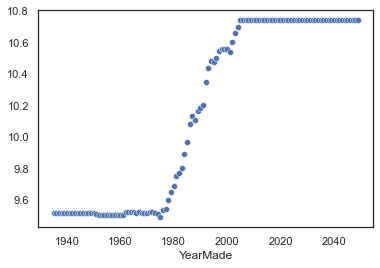

In [121]:
sns.scatterplot(x=tabela_pred['YearMade'], y = ypred)

<b> <font color="red"> O que aconteceria se fosse um modelo de regressão linear? </font> </b> 

## Interpretabilidade modelo e SHAP 

SHAP (SHapley Additive exPlanations) é uma biblioteca que, recentemente, ganhou muito destaque para interpretar os modelos "caixa preta". Com ela, podemos entender não só o que o modelo prediz, mas por que ele prediz tal valor.  

https://github.com/slundberg/shap

<b> Dica de livro (gratuito) </b>: Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/

In [ ]:
!pip install shap

In [1]:
import shap

Primeiro criamos um objeto explainer: 

In [7]:
explainer = shap.Explainer(modelo)

In [309]:
%time shap_values = explainer(validation.sample(n=500)[features])

Wall time: 16min 55s


In [310]:
with open('../models/shap_rf.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

In [124]:
with open('../models/shap_rf.pkl', 'rb') as file:
    shap_values = pickle.load(file)

Vamos inspecionar o que o shap_values nos traz:

In [125]:
shap_values[0]

.values =
array([-0.01408303, -0.02614325, -0.03293299,  0.23571192, -0.0040212 ,
       -0.06141568, -0.023885  , -0.09658066,  0.0176465 ,  0.03385196,
       -0.43144687, -0.3600959 , -0.02825826, -0.07356479, -0.02034059])

.base_values =
array([10.09946847])

.data =
array([   4380869,    2313207,      17439,       2003,       3391,
                0,          0,          0,         40,          1,
                1,          2,       2011, 1319500800,       1197],
      dtype=int64)

Gerando uma explicação individual:

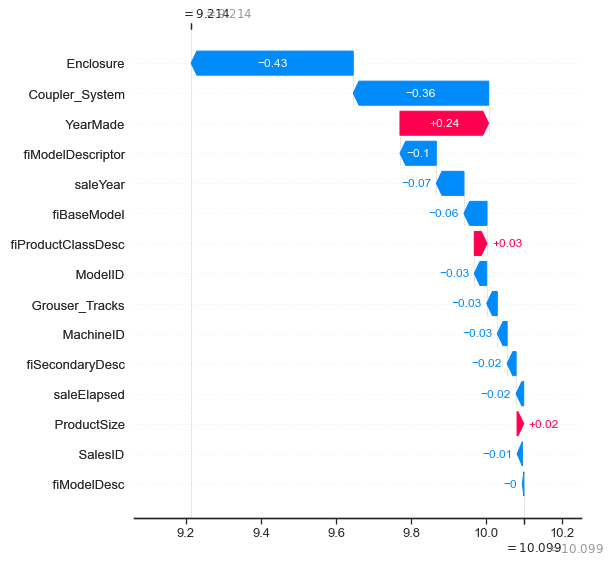

In [126]:
#obs: estamos utilizando essa função waterfall_legacy porque 
#a função original, na data de criação do material, estava gerando um bug
shap.plots._waterfall.waterfall_legacy(
    expected_value = shap_values[0].base_values[0], 
    shap_values = shap_values[0].values, 
    features = shap_values[0].data, 
    feature_names = features, 
    max_display = 20
)

Podemos usar esses valores para criar uma visualização interativa:

In [127]:
explicacao_shap = pd.DataFrame(
    data = zip(
        features_mais_filtradas,
        shap_values[0].data,
        shap_values[0].values),
    columns = [
        'feature',
        'valor_da_feature',
        'impacto_shap'
    ])

Vamos ordenar do menor para o maior impacto do shap:

In [128]:
explicacao_shap = explicacao_shap.sort_values(
    by='impacto_shap', 
    ascending=False, key=abs).reset_index(drop=True) # key=abs para ordenar pelo módulo

In [129]:
explicacao_shap['measure'] = 'relative'

In [130]:
explicacao_shap

,feature,valor_da_feature,impacto_shap,measure
0,Enclosure,1,-0.431447,relative
1,Coupler_System,2,-0.360096,relative
2,YearMade,2003,0.235712,relative
3,fiModelDescriptor,0,-0.096581,relative
4,saleYear,1319500800,-0.073565,relative
5,fiBaseModel,0,-0.061416,relative
6,fiProductClassDesc,1,0.033852,relative
7,ModelID,17439,-0.032933,relative
8,Grouser_Tracks,2011,-0.028258,relative
9,MachineID,2313207,-0.026143,relative


Agora vamos adicionar o base value (ponto de partida):

In [131]:
df_base_value = pd.DataFrame(
    data = [{
        'feature': 'Valor Base',
        'valor_da_feature': "Valor Base",
        'impacto_shap' : shap_values[0].base_values[0],
        'measure': 'relative'
    }])

In [132]:
df_base_value

,feature,valor_da_feature,impacto_shap,measure
0,Valor Base,Valor Base,10.099468,relative


In [133]:
df_valor_final = pd.DataFrame(
    data = [{
        'feature': 'Predição final',
        'valor_da_feature': 'Valor final',
        'impacto_shap' : df_base_value['impacto_shap'][0] + explicacao_shap['impacto_shap'].sum(),
        'measure': 'total'
    }])

In [134]:
df_valor_final

,feature,valor_da_feature,impacto_shap,measure
0,Predição final,Valor final,9.213911,total


In [135]:
tabela_para_cascata = pd.concat([df_base_value, explicacao_shap, df_valor_final], ignore_index=True)

In [136]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = tabela_para_cascata['measure'].tolist(),
    x = tabela_para_cascata['feature'],
    textposition = "outside",
    hovertext = tabela_para_cascata['valor_da_feature'],
    y = tabela_para_cascata['impacto_shap'],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

In [138]:
fig.update_layout({
    'title': 'Meu gráfico cascata interativo!',
    'yaxis_range': (9,10.4),
    'xaxis_title': 'Variável',
    'yaxis_title': 'Impacto SHAP'
})

<b> Desafio: </b> faça uma função que tenha opção de mostrar um número máximo de variáveis. Para as que ficaram com menor impacto, agrupe o efeito delas numa coluna chamada "outros impactos (X variáveis)"

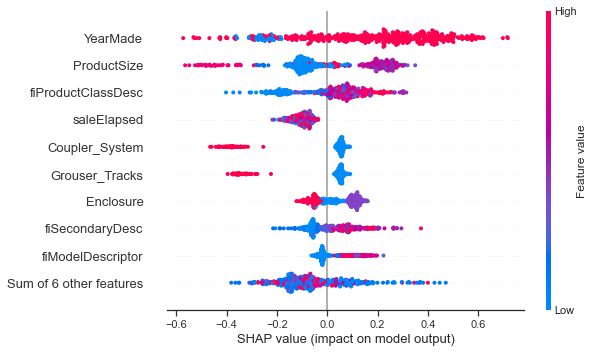

In [139]:
shap.plots.beeswarm(shap_values)

In [140]:
shap.initjs()

In [141]:
shap.force_plot(
    base_value = shap_values.base_values[0],
    shap_values = shap_values.values,
    features = shap_values.data, 
    feature_names = features, 
)

# Indo além do RandomForest

Na década de 90, o modelo RandomForest trouxe o conceito de bagging e foi um dos grandes avanços nos modelos baseados em árvores de decisão. De lá para cá tivemos importantes inovações, como o <b> Boosting </b>:

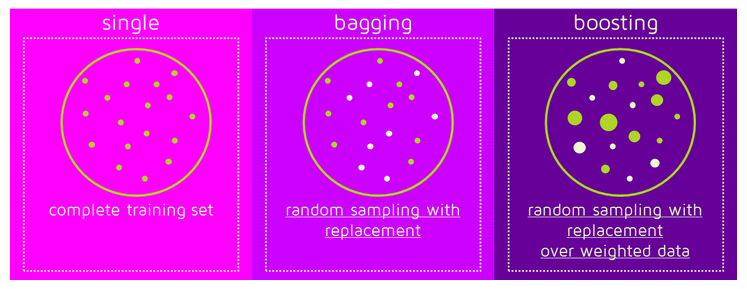

In [142]:
Image('../figures/bagging_vs_boosting.png')

FONTE: https://www.kdnuggets.com/2017/11/difference-bagging-boosting.html

Alguns modelos de ensemble de árvores muito robustos (e rápidos). Note que cada modelo tem hiperparâmetros diferentes:

XGBoost (Extreme Gradient boosting): https://xgboost.readthedocs.io/en/latest/install.html

CatBoost: https://catboost.ai/

LightGBM: https://lightgbm.readthedocs.io/en/latest/index.html

In [ ]:
!pip install lightgbm

In [143]:
from lightgbm.sklearn import LGBMRegressor

In [144]:
modelo_lgbm = LGBMRegressor()

In [155]:
params = {
    'n_estimators': np.arange(20, 500, 5),
    'num_leaves': np.arange(20, 50, 3),
    'subsample': [0.3, 0.5, 0.8, 1]
}

In [156]:
grid_lgbm = RandomizedSearchCV(
    estimator = LGBMRegressor(), 
    param_distributions = params,
    n_iter=30, #número de combinações que vamos amostrar aleatoriamente para testar
    n_jobs=-1,
    cv = SplitterPersonalizado(), #especificar a estratégia de validação cruzada
    verbose=10
)

In [157]:
%time grid_lgbm.fit(X=df[features], y=df[output])

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Wall time: 2min 2s


RandomizedSearchCV(cv=<__main__.SplitterPersonalizado object at 0x0000019522FCFE48>,
                   estimator=LGBMRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'n_estimators': array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210,
       215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275,
       280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340,
       345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405,
       410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470,
       475, 480, 485, 490, 495]),
                                        'num_leaves': array([20, 23, 26, 29, 32, 35, 38, 41, 44, 47]),
                                        'subsample': [0.3, 0.5, 0.8, 1]},
                   verbose=10)

In [158]:
with open('../models/grid_lgbm.pkl', 'wb') as file:
    pickle.dump(grid_lgbm, file)

In [159]:
with open('../models/grid_lgbm.pkl', 'rb') as file:
    grid_lgbm = pickle.load(file)

In [160]:
modelo_lgbm = grid_lgbm.best_estimator_

In [161]:
best_params = grid_lgbm.best_params_

In [162]:
best_params

{'subsample': 0.3, 'num_leaves': 47, 'n_estimators': 390}

In [163]:
score_model(train, validation, features,output, modelo_lgbm)

{'mean_squared_error_train': 0.046,
 'mean_squared_error_valid': 0.047,
 'rmse_train': 0.214,
 'rmse_valid': 0.217,
 'mean_absolute_error_train': 0.16,
 'mean_absolute_error_valid': 0.163,
 'r2_score_train': 0.904,
 'r2_score_valid': 0.908}

Desempenho um pouco menor que o RandomForest nesse caso. Lembre que é necessário ajustar os hiperparâmetros desse novo modelo

In [164]:
explainer_lgbm = shap.Explainer(modelo_lgbm)

In [165]:
%time shap_values = explainer_lgbm(validation[features])

Wall time: 34.9 s


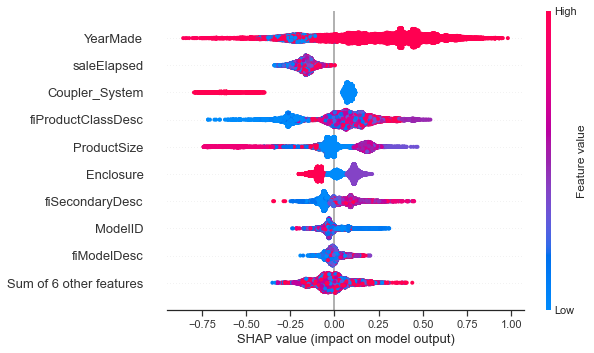

In [166]:
shap.plots.beeswarm(shap_values)